# Procedure for image preprocessing

## Setup

In [208]:
# %matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import cv2
from PIL import ImageStat
import random
import os
from dotenv import load_dotenv


In [80]:
load_dotenv()
os.environ.get('TRAINING_DIRECTORY')


'C:/Users/nikla/Documents/Semester6/data/cucumber-dataset-compressed/normal-light'

## Define constants and read the data

In [81]:
# Set the path to the folders containing the images
# train_dir = './training_data/'
train_dir = os.environ.get('TRAINING_DIRECTORY')

# Define the image size
img_height = 1024
img_width = 1024

# Define the batch size
batch_size = 32


In [82]:
# Read in the images and resize them
classes = ['healthy', 'infected']
images = []
labels = []
img_paths = []
img_dir = f'{train_dir}/mini-healthy'
for img_file in os.listdir(img_dir):
    path = os.path.join(img_dir, img_file)
    img = tf.keras.preprocessing.image.load_img(
        path, target_size=(img_height, img_width))
    img = tf.keras.preprocessing.image.img_to_array(img, dtype=np.uint8)
    images.append(img)
    labels.append(0)
    img_paths.append(path)

img_dir = f'{train_dir}/mini-infected'
for img_file in os.listdir(img_dir):
    path = os.path.join(img_dir, img_file)
    img = tf.keras.preprocessing.image.load_img(
        path, target_size=(img_height, img_width))
    img = tf.keras.preprocessing.image.img_to_array(img, dtype=np.uint8)
    images.append(img)
    labels.append(1)
    img_paths.append(path)

# Convert the data and labels to NumPy arrays
images = np.array(images)
labels = np.array(labels)
img_paths = np.array(img_paths)


In [83]:
images.shape

(300, 1024, 1024, 3)

## Store some information about the dataset into a Dataframe

In [239]:
# Get the first y-pixel value where at least 1/64 of the pixels are masked
MASK_BLUE_THRESHOLD = 130

def get_first_and_last_cucumber_pixel(image):
    masked_img = (image[..., 2] < MASK_BLUE_THRESHOLD)

    first_cucumber_pixel_y = None
    last_cucumber_pixel_y = None
    threshold = img_width / 64
    for i in range(masked_img.shape[0]):
        if np.sum(masked_img[i, :]) > threshold:
            first_cucumber_pixel_y = i
            j = first_cucumber_pixel_y
            for j in range(i, masked_img.shape[0]):
                if np.sum(masked_img[j, :]) <= threshold:
                    last_cucumber_pixel_y = j
                    break
            break

    first_cucumber_pixel_x = None
    last_cucumber_pixel_x = None
    threshold = 2
    for i in range(masked_img.shape[1]):
        if np.sum(masked_img[:, i]) > threshold:
            first_cucumber_pixel_x = i
            j = first_cucumber_pixel_x
            for j in range(i, masked_img.shape[0]):
                if np.sum(masked_img[:, j]) <= threshold:
                    last_cucumber_pixel_x = j
                    break
            break

    return ((first_cucumber_pixel_x, first_cucumber_pixel_y), (last_cucumber_pixel_x, last_cucumber_pixel_y))


In [256]:
# Create the DataFrame

df_records = []
for i in range(images.shape[0]):
    ((first_x, first_y), (last_x, last_y)
     ) = get_first_and_last_cucumber_pixel(images[i])
    df_records.append(
        {'idx': i, 
         'label': classes[labels[i]], 
         'first_cucumber_pixel_y': first_y, 
         'last_cucumber_pixel_y': last_y, 
         'first_cucumber_pixel_x': first_x, 
         'last_cucumber_pixel_x': last_x, 
         'cucumber_height': last_y - first_y,
         'cucumber_width': last_x - first_x
         })

df = pd.DataFrame(df_records)

print(df)


     idx     label  first_cucumber_pixel_y  last_cucumber_pixel_y  \
0      0   healthy                     333                    572   
1      1   healthy                     331                    565   
2      2   healthy                     327                    609   
3      3   healthy                     352                    570   
4      4   healthy                     324                    558   
..   ...       ...                     ...                    ...   
295  295  infected                     311                    643   
296  296  infected                     311                    558   
297  297  infected                     332                    581   
298  298  infected                     311                    581   
299  299  infected                     349                    636   

     first_cucumber_pixel_x  last_cucumber_pixel_x  cucumber_height  \
0                       163                    848              239   
1                       151  

## Plot some random images with their label and a line for the first "cucumber pixel" detected

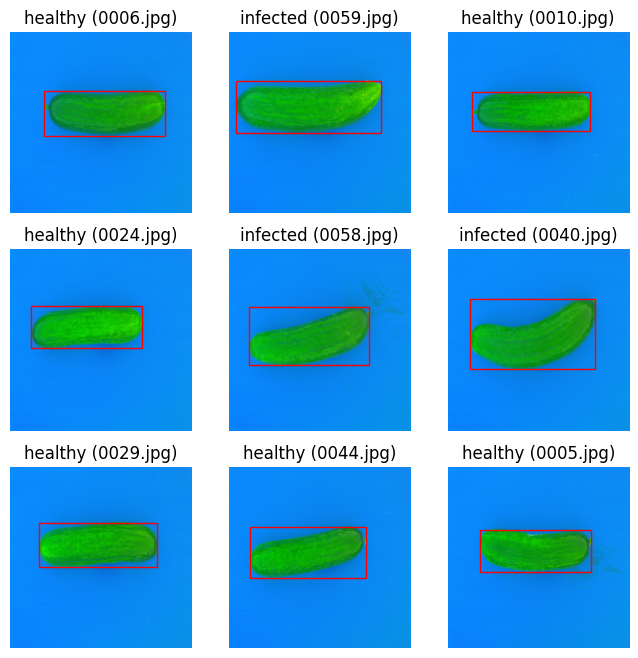

In [257]:
# Plot some random images with their label and a line for the first "cucumber pixel" detected
plt.figure(figsize=(8, 8))
# rand = random.randint(0, images.shape[0] - 10)
for i in range(9):
    rand_idx = random.randint(0, images.shape[0] - 1)
    # rand_idx = rand + i
    # rand_idx = 25 + i
    ax = plt.subplot(3, 3, i + 1)
    rect = patches.Rectangle(
        (df.iloc[rand_idx]['first_cucumber_pixel_x'], 
         df.iloc[rand_idx]['first_cucumber_pixel_y']), 
         df.iloc[rand_idx]['last_cucumber_pixel_x'] - df.iloc[rand_idx]['first_cucumber_pixel_x'], 
         df.iloc[rand_idx]['last_cucumber_pixel_y'] - df.iloc[rand_idx]['first_cucumber_pixel_y'],
        linewidth=1, 
        edgecolor='r', 
        facecolor='none')
    
    ax.add_patch(rect)
    plt.imshow(images[rand_idx])
    path = img_paths[rand_idx].split(os.sep)[-1]
    plt.title(f'{classes[labels[rand_idx]]} ({path})')
    plt.axis('off')


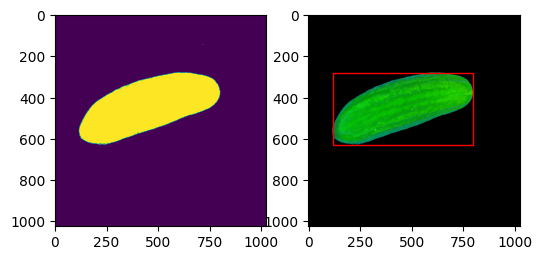

In [273]:
idx = random.randint(0, images.shape[0] - 1)
image = images[idx]
masked_img = (image[..., 2] < MASK_BLUE_THRESHOLD)

# Get the first y-pixel value where at least 1/64 of the pixels are masked
first_cucumber_pixel_y = None
threshold = img_width / 64
for i in range(masked_img.shape[0]):
    if np.sum(masked_img[i, :]) > threshold:
        first_cucumber_pixel_y = i
        break

img_mask_reshaped = np.zeros((*masked_img.shape, 3))
img_mask_reshaped[np.where(masked_img)] = [1, 1, 1]

plt.figure(figsize=(6, 6))
plt.subplot(1, 2, 1)
plt.imshow(masked_img)
ax = plt.subplot(1, 2, 2)
rect = patches.Rectangle(
    (df.iloc[idx]['first_cucumber_pixel_x'],
     df.iloc[idx]['first_cucumber_pixel_y']),
    df.iloc[idx]['last_cucumber_pixel_x'] -
    df.iloc[idx]['first_cucumber_pixel_x'],
    df.iloc[idx]['last_cucumber_pixel_y'] -
    df.iloc[idx]['first_cucumber_pixel_y'],
    linewidth=1,
    edgecolor='r',
    facecolor='none')

ax.add_patch(rect)
plt.imshow(np.multiply(image, img_mask_reshaped).astype(np.uint))
plt.show()


In [259]:
print(f'Images infected: {(len(df[df["label"]=="infected"]))}')
print(f'Images healthy: {(len(df[df["label"]=="healthy"]))}')

Images infected: 144
Images healthy: 156


In [260]:
df_sorted_by_height = df.sort_values('cucumber_height', ascending=False)
img_paths[df_sorted_by_height['idx'][:10]]


array(['C:/Users/nikla/Documents/Semester6/data/cucumber-dataset-compressed/normal-light/mini-infected\\0123.jpg',
       'C:/Users/nikla/Documents/Semester6/data/cucumber-dataset-compressed/normal-light/mini-infected\\0127.jpg',
       'C:/Users/nikla/Documents/Semester6/data/cucumber-dataset-compressed/normal-light/mini-infected\\0131.jpg',
       'C:/Users/nikla/Documents/Semester6/data/cucumber-dataset-compressed/normal-light/mini-infected\\0120.jpg',
       'C:/Users/nikla/Documents/Semester6/data/cucumber-dataset-compressed/normal-light/mini-healthy\\0132.jpg',
       'C:/Users/nikla/Documents/Semester6/data/cucumber-dataset-compressed/normal-light/mini-infected\\0136.jpg',
       'C:/Users/nikla/Documents/Semester6/data/cucumber-dataset-compressed/normal-light/mini-healthy\\0143.jpg',
       'C:/Users/nikla/Documents/Semester6/data/cucumber-dataset-compressed/normal-light/mini-healthy\\0133.jpg',
       'C:/Users/nikla/Documents/Semester6/data/cucumber-dataset-compressed/normal-

In [261]:
img_paths[df[df['first_cucumber_pixel_y'] < 4]['idx']]


array([], dtype='<U103')

In [262]:
img_paths[df[df['last_cucumber_pixel_y'] > img_height - 4]['idx']]


array([], dtype='<U103')

In [282]:
# Crop images to both tips
idx = random.randint(0, images.shape[0] - 1)
image = images[idx]
df_entry = df.iloc[idx]

total_height = df_entry['cucumber_height']
total_width = df_entry['cucumber_width']

if (total_height > total_width):
    raise ValueError('Cucumber height is bigger than width')

img_left = image[df_entry['first_cucumber_pixel_y']:df_entry['last_cucumber_pixel_y'],
                   df_entry['first_cucumber_pixel_x']:df_entry['first_cucumber_pixel_x'] + total_height,]

img_right = image[df_entry['first_cucumber_pixel_y']:df_entry['last_cucumber_pixel_y'],
                  df_entry['last_cucumber_pixel_x'] - total_height:df_entry['last_cucumber_pixel_x'],]

img_left = cv2.resize(img_left, dsize=(
    224, 224), interpolation=cv2.INTER_CUBIC)

img_right = cv2.resize(img_right, dsize=(
    224, 224), interpolation=cv2.INTER_CUBIC)


In [283]:
# Remove background
masked_img_left = (img_left[..., 2] < MASK_BLUE_THRESHOLD)
img_mask_reshaped_left = np.zeros((*masked_img_left.shape, 3))
img_mask_reshaped_left[np.where(masked_img_left)] = [1, 1, 1]

masked_img_right = (img_right[..., 2] < MASK_BLUE_THRESHOLD)
img_mask_reshaped_right = np.zeros((*masked_img_right.shape, 3))
img_mask_reshaped_right[np.where(masked_img_right)] = [1, 1, 1]

img_left = np.multiply(img_left, img_mask_reshaped_left).astype(np.uint)
img_right = np.multiply(img_right, img_mask_reshaped_right).astype(np.uint)


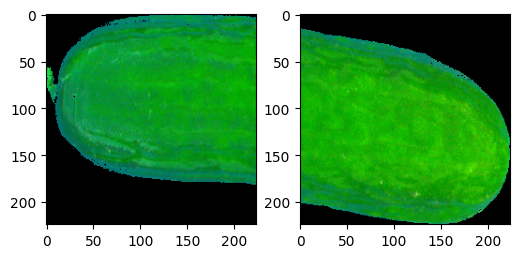

In [284]:
plt.figure(figsize=(6, 6))
plt.subplot(2, 2, 1)
plt.imshow(img_left, cmap=plt.get_cmap('gray'))
plt.subplot(2, 2, 2)
plt.imshow(img_right, cmap=plt.get_cmap('gray'))

plt.show()


(224, 224, 3)
(224, 224, 3)


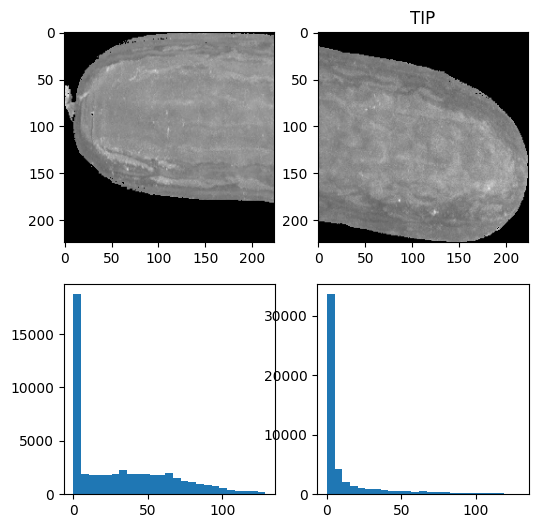

In [285]:
print(img_left.shape)
print(img_right.shape)

img_left_grey = np.dot(img_left[..., :], [0.2989, 0.5870, 0.1140])
img_right_grey = np.dot(img_right[..., :], [0.2989, 0.5870, 0.1140])

mean_brightness_left = np.mean(img_left_grey, axis=None)
mean_brightness_right = np.mean(img_right_grey, axis=None)

plt.figure(figsize=(6, 6))
plt.subplot(2, 2, 1)
plt.imshow(img_left_grey, cmap=plt.get_cmap('gray'))
if (mean_brightness_left > mean_brightness_right):
    plt.title("TIP")

plt.subplot(2, 2, 2)
plt.imshow(img_right_grey, cmap=plt.get_cmap('gray'))
if (mean_brightness_right > mean_brightness_left):
    plt.title("TIP")

plt.subplot(2, 2, 3)
plt.hist(img_left[...,2].ravel(), bins=25)

plt.subplot(2, 2, 4)
plt.hist((img_right[..., 2].ravel()), bins=25)


plt.show()

